In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [680]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor(),download=True
    ),
    
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label < 40
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



In [681]:
import matplotlib.pyplot as plt

In [682]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 2, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        
        return self.conv6(x)
    
class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.dense1 = nn.Linear(28 * 28 * 2, 8000)
        self.dense2 = nn.Linear(8000, 3000)
        self.dense3 = nn.Linear(3000, 28 * 28 * 2)
    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * 28 * 28))
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        x = torch.reshape(x, (-1, 2, 28, 28))
        return x
        


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        
        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
       
        
        self.regis_net = FCNet().cuda()
        

    def forward(self, moving_image, fixed_image):
        

        self.phi1 = self.regis_net(moving_image, fixed_image) + self.identityMap
        
        self.phiinv = self.regis_net(fixed_image, moving_image) + self.identityMap
        
        self.warped_moving_image = py_utils.compute_warped_image_multiNC(
            moving_image, self.phi1, self.spacing, 1)
        
        self.warped_fixed_image = py_utils.compute_warped_image_multiNC(
            fixed_image, self.phiinv, self.spacing, 1)
        
        self.fake_ident = py_utils.compute_warped_image_multiNC(
            self.phiinv, self.phi1, self.spacing, 1)
        
        regularization_loss = 300 * torch.mean(
            (self.identityMap - self.fake_ident)**2)
        similarity_loss = (
            torch.mean((self.warped_moving_image - fixed_image)**2) + 
            torch.mean((self.warped_fixed_image - moving_image)**2)
        )
        #print(regularization_loss, similarity_loss)
        
        self.all_loss = regularization_loss + similarity_loss


net = MermaidNet()
0

0

In [683]:
optimizer = torch.optim.Adam(net.parameters(), lr=.00001)

In [684]:
net.train()

MermaidNet(
  (regis_net): FCNet(
    (dense1): Linear(in_features=1568, out_features=8000, bias=True)
    (dense2): Linear(in_features=8000, out_features=3000, bias=True)
    (dense3): Linear(in_features=3000, out_features=1568, bias=True)
  )
)

In [744]:
for _ in range(100):
    print("dep")
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == 128:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.all_loss
            
            loss.backward()
            
            optimizer.step()
    print(loss.item())


dep


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


0.11384837329387665
dep
0.10321345180273056
dep
0.1072705090045929
dep
0.10657837986946106
dep
0.10472777485847473
dep
0.09969605505466461
dep
0.09994933009147644
dep
0.09755644202232361
dep
0.10239539295434952
dep
0.10249848663806915
dep
0.09908650815486908
dep
0.09970176219940186
dep
0.09900428354740143
dep
0.09647348523139954
dep
0.09770358353853226
dep
0.09574299305677414
dep
0.09616577625274658
dep
0.09053972363471985
dep
0.10208471119403839
dep
0.09461897611618042
dep
0.0902642235159874
dep
0.09333239495754242
dep
0.09738701581954956
dep
0.09852970391511917
dep


KeyboardInterrupt: 

In [745]:
#moving_image = list(d1)[0][0][:1].cuda()
#fixed_image = list(d2)[0][0][:1].cuda()

In [746]:
#for _ in range(10):
    optimizer.zero_grad()
    net(fixed_image, moving_image)
    loss = net.all_loss

    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    net(moving_image, fixed_image)
    loss = net.all_loss

    loss.backward()
    optimizer.step()

IndentationError: unexpected indent (<ipython-input-746-60171b53d183>, line 2)

In [747]:
#moving, fixed = list(zip(d1, d2))[0]
#moving_image = moving[0].cuda()
#fixed_image = fixed[0].cuda()

#net(moving_image, fixed_image)

phi = np.array((net.phi1).cpu().detach())
iden = np.array(net.identityMap.cpu())

In [748]:
iden.shape

(128, 2, 28, 28)

In [749]:
N = 0

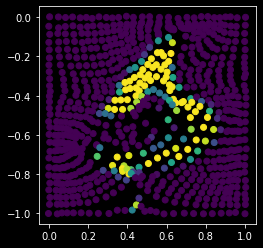

In [750]:
N += 1
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

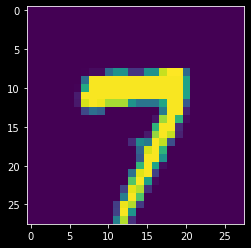

In [751]:
plt.imshow(fixed_image[N, 0].cpu().numpy())

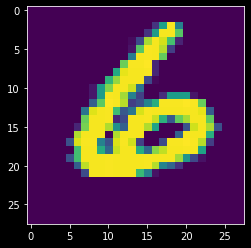

In [752]:
plt.imshow(moving_image[N, 0].cpu().numpy())

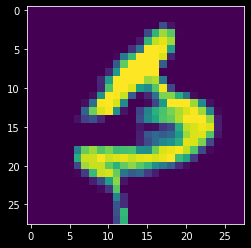

In [753]:
plt.imshow(net.warped_fixed_image[N, 0].detach().cpu())

In [754]:
def get_phi(a, b):
    net(a, b)
    return net.phi1.detach().cpu()

In [755]:
phi2 = get_phi(fixed_image, moving_image)
phi1 = get_phi(moving_image, fixed_image)


/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


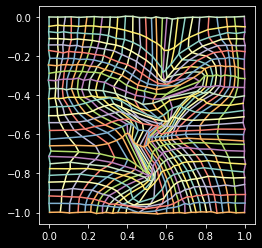

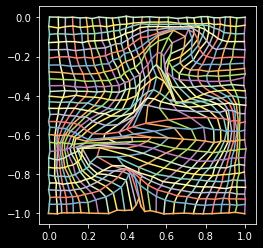

In [756]:
def grid(A, B):
    plt.axes().set_aspect("equal")
    plt.plot(A, B)
    plt.plot(A.transpose(0, 1), B.transpose(0, 1))
    
def grd(d):
    grid(d[1], d[0])


grid(phi2[N, 1], -phi2[N, 0])
plt.show()
grid(phi1[N, 1], -phi1[N, 0])

In [757]:
grid

<function __main__.grid(A, B)>

In [758]:
ident_hope = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


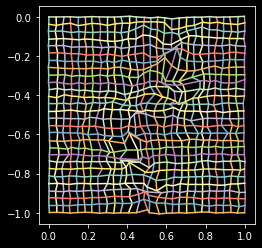

In [759]:
grid(ident_hope[N, 1], -ident_hope[N, 0])

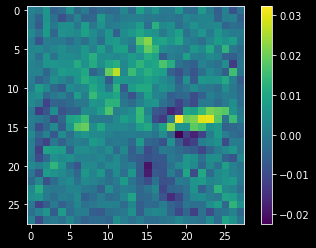

In [625]:
plt.imshow(ident_hope[N, 1] - iden[N, 1])
plt.colorbar()

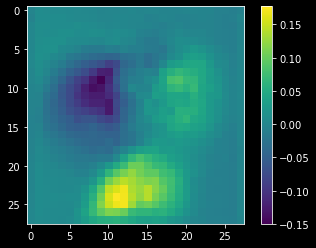

In [83]:
plt.imshow(phi2[N, 1] - iden[N, 1])
plt.colorbar()

In [27]:
net.phi.size()

torch.Size([128, 2, 28, 28])

In [68]:
grid(phi1)

TypeError: grid() missing 1 required positional argument: 'B'

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


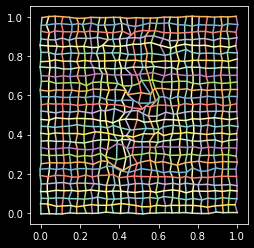

In [609]:
phi1_inv = py_utils.compute_warped_image_multiNC(phi2, phi1, net.spacing, 1)
grd(phi1_inv[N])

/playpen-raid1/tgreer/anaconda3/envs/mermaid4/lib/python3.7/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


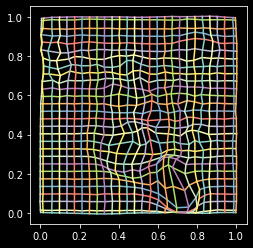

In [97]:
id_ = net.identityMap.cpu().numpy()

phi1_disp = phi1.numpy() - id_

mphi1 = id_ - phi1_disp

phi1inv = py_utils.compute_warped_image_multiNC(phi1, torch.tensor(mphi1), net.spacing, 1)

grd(phi1inv[N])

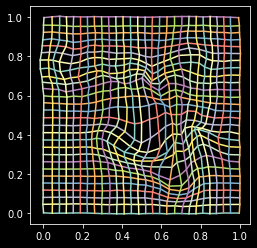

In [98]:
grd(phi2[N])

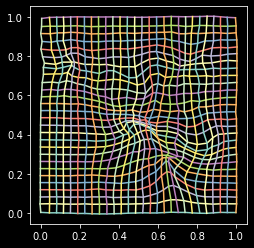

In [100]:
grd(phi1[N])

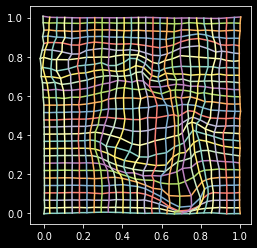

In [105]:
grd(torch.tensor(mphi1)[N])

In [104]:
phi1.shape

torch.Size([128, 2, 28, 28])